# Machine Learning Project - Car Price Prediction

The aim of this project is to predict car prices in Polish currency (zloty), based on their features such as year of production, engine volume, etc.

To solve this problem there were used the best known AI techniques for this type of task: 
* MLP Neural Network
* XGBoost Algorithm

Data source: https://www.kaggle.com/datasets/krzysztofdogowski/used-cars-poland-with-links-may-2022

Data comes from the Polish website https://www.otomoto.pl/ from May 2022.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from matplotlib.pyplot import figure
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from xgboost import XGBRegressor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path_to_directory = "drive/MyDrive/"

Mounted at /content/drive


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 10000
LEARNING_RATE = 0.009
NUMBER_OF_EPOCH = 480
RANDOM_STATE = 123

print(f"Device: {device.type}")

Device: cuda


# Load data

In [4]:
df = pd.read_csv(f"{path_to_directory}car_prices.csv")
df = df.drop(["title", "link"], axis=1)
df = df.drop_duplicates()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140259 entries, 0 to 152942
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   mark        140259 non-null  object
 1   model       140259 non-null  object
 2   price       140259 non-null  int64 
 3   year        140259 non-null  int64 
 4   mileage     140259 non-null  int64 
 5   vol_engine  140259 non-null  int64 
 6   fuel        140259 non-null  object
dtypes: int64(4), object(3)
memory usage: 8.6+ MB


In [6]:
df.head()

,mark,model,price,year,mileage,vol_engine,fuel
0,opel,combo,33000,2018,174069,1248,Diesel
1,opel,combo,65900,2018,53647,1598,Diesel
2,opel,combo,84900,2019,37700,1499,Diesel
3,opel,combo,70900,2019,117987,1499,Diesel
4,opel,combo,81180,2018,27000,1499,Diesel


# Data overview & preprocessing

In [7]:
df["fuel"].value_counts()

Benzyna        75047
Diesel         61709
Hybryda         2950
Elektryczny      550
LPG                3
Name: fuel, dtype: int64

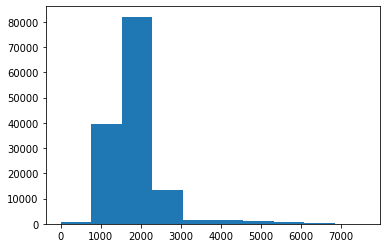

In [8]:
plt.hist(df["vol_engine"]);

In [9]:
df[df["year"] > 2022]

,mark,model,price,year,mileage,vol_engine,fuel
27510,audi,rs6,775800,2023,10,3996,Benzyna


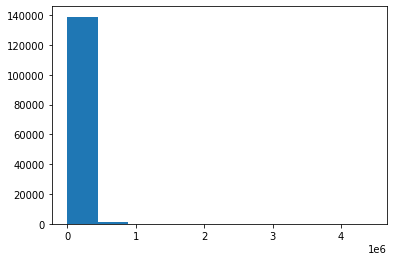

In [10]:
plt.hist(df["price"]);

In [11]:
print(len(df[df["price"] > 500_000]))

847


In [12]:
# only 3 records with fuel LPG
df = df[df["fuel"] != "LPG"]

# get only nonelectric cars
df = df[df["vol_engine"] > 500]

# Over than 99% of cars are priced below 500_000 zloty, so we can reduce the price to 500_000 zloty
df = df[df["price"] < 500_000]

# one new car with 2023 year (dataset from 2022)
df.loc[df["year"] == 2023, "year"] = 2022
df = pd.get_dummies(df, columns=["mark", "model", "fuel"])

# Split & Scale

In [13]:
X = df.drop("price", axis=1)
y = df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE)

X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

FEATURES = X_train.shape[1]
FEATURES

349

# MLP Neural Network

In [14]:
class NeuralNetworkModel(torch.nn.Module):
    def __init__(self):
        super(NeuralNetworkModel, self).__init__()

        self.net = torch.nn.Sequential(
            torch.nn.Linear(FEATURES, 200),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(200),
            torch.nn.Linear(200, 200),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(200),
            torch.nn.Linear(200, 100),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(100),
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(50),
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 1),
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [15]:
torch.cuda.manual_seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE) 

model = NeuralNetworkModel().to(device=device)
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=60, eta_min=0.00001)

dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
train_loss = []

for epoch in (pbar := tqdm(range(NUMBER_OF_EPOCH))):
    current_loss = 0.0
    items_total = 0
    model.train()

    for i, (X, Y) in enumerate(dataloader):
        X = X.to(device)
        Y = Y.to(device).float()

        Y_predictions = model(X.float())
        items_total += Y.shape[0]

        optimizer.zero_grad()
        loss = criterion(Y_predictions, Y)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()

    scheduler.step()
    train_loss.append(current_loss)
    pbar.set_description(f"Loss: {current_loss}")

model.eval()

Loss: 0.6237770617008209: 100%|██████████| 480/480 [23:35<00:00,  2.95s/it]


NeuralNetworkModel(
  (net): Sequential(
    (0): Linear(in_features=349, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=200, out_features=100, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=100, out_features=50, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=50, out_features=25, bias=True)
    (13): ReLU()
    (14): Linear(in_features=25, out_features=1, bias=True)
  )
)

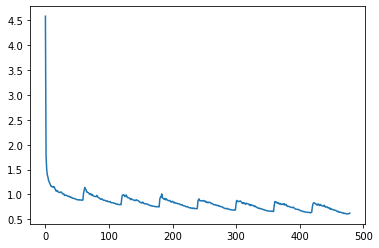

In [17]:
plt.plot(train_loss);

## More accurate plot (after 60 first epochs)

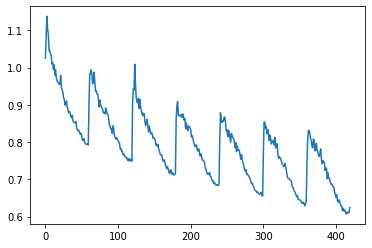

In [18]:
plt.plot(train_loss[60:]);

# MLP Neural Network Metrics

In [19]:
test_predict = model(torch.tensor(X_test.astype(np.float32)).to(device))
test_predict = test_predict.cpu().detach().numpy()
rescaled_test_predict = y_scaler.inverse_transform(test_predict)

rescaled_test_real = y_scaler.inverse_transform(y_test)

mae = mean_absolute_error(rescaled_test_predict, rescaled_test_real)
print("MAE metric:")
print(round(mae, 2))

mape = mean_absolute_percentage_error(rescaled_test_predict, rescaled_test_real)
print("MAPE metric:")
print(f"{round(mape*100, 2)} %")

mse = mean_squared_error(rescaled_test_predict, rescaled_test_real)
print("MSE metric:")
print(round(mse, 2))

MAE metric:
10081.31
MAPE metric:
16.57 %
MSE metric:
409947589.47


# XGBoost

In [20]:
xgb_params = {
    'objective' : 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 15,
    'n_estimators': 150,
    'tree_method':'gpu_hist',
    }

xgb_model =  XGBRegressor(**xgb_params)
xgb_model.fit(X_train, y_train)


XGBRegressor(max_depth=15, n_estimators=150, objective='reg:squarederror',
             tree_method='gpu_hist')

# XGBoost Metrics

In [21]:
xgb_test_predict = xgb_model.predict(X_test)

xgb_rescaled_test_predict = y_scaler.inverse_transform(xgb_test_predict.reshape(-1, 1))
rescaled_test_real = y_scaler.inverse_transform(y_test)

mae = mean_absolute_error(xgb_rescaled_test_predict, rescaled_test_real)
print("MAE metric:")
print(round(mae, 2))

mape = mean_absolute_percentage_error(xgb_rescaled_test_predict, rescaled_test_real)
print("MAPE metric:")
print(f"{round(mape*100, 2)} %")

mse = mean_squared_error(xgb_rescaled_test_predict, rescaled_test_real)
print("MSE metric:")
print(round(mse, 2))

MAE metric:
10187.41
MAPE metric:
16.28 %
MSE metric:
407618397.58


# Mean of predictions metrics

In [22]:
zipped_predictions = zip(list(rescaled_test_predict), list(xgb_rescaled_test_predict))
rescaled_test_predict = [(x+y) / 2 for x, y in zipped_predictions]

mae = mean_absolute_error(rescaled_test_predict, rescaled_test_real)
print("MAE metric:")
print(round(mae, 2))

mape = mean_absolute_percentage_error(rescaled_test_predict, rescaled_test_real)
print("MAPE metric:")
print(f"{round(mape*100, 2)} %")

mse = mean_squared_error(rescaled_test_predict, rescaled_test_real)
print("MSE metric:")
print(round(mse, 2))

MAE metric:
9835.72
MAPE metric:
15.71 %
MSE metric:
382884991.4


# Overall cost price comparison
# Mean of two models predictions will be used as the final prediction

In [23]:
rescaled_test_real = list(rescaled_test_real)

# single pair consists of actual price of a car and the predicted one
sorted_pairs = sorted(zip(rescaled_test_real, rescaled_test_predict), key=lambda x: x[0])

In [24]:
pairs_to_plot = [pair for idx, pair in enumerate(sorted_pairs) if idx % 250 == 0]
indexes = [x for x in range(len(pairs_to_plot))]

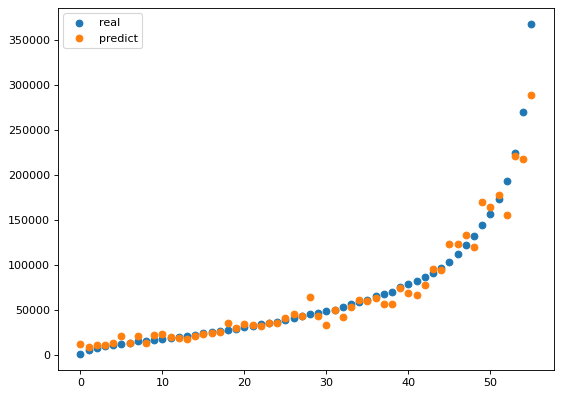

In [25]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.scatter(indexes, [x[0] for x in pairs_to_plot], label = "real")
plt.scatter(indexes, [x[1] for x in pairs_to_plot], label = "predict")
plt.legend()
plt.show()

# Low cost cars price comparison (less than 100_000)

In [38]:
low_cost_pairs = [x for x in sorted_pairs if x[0] < 100_000]
low_cost_pairs_to_plot = [pair for idx, pair in enumerate(low_cost_pairs) if idx % 250 == 0]
low_cost_indexes = [x for x in range(len(low_cost_pairs_to_plot))]

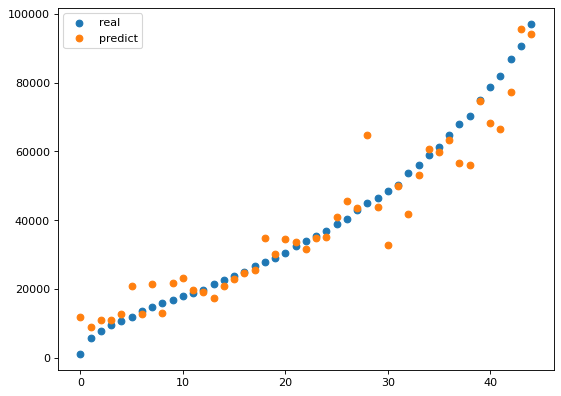

In [39]:
figure(figsize=(8, 6), dpi=80)

plt.scatter(low_cost_indexes, [x[0] for x in low_cost_pairs_to_plot], label = "real")
plt.scatter(low_cost_indexes, [x[1] for x in low_cost_pairs_to_plot], label = "predict")
plt.legend()
plt.show()

# High cost price comparison (higher than 100_000)

In [42]:
high_cost_pairs = [x for x in sorted_pairs if x[0] > 100_000]
high_cost_pairs_to_plot = [pair for idx, pair in enumerate(high_cost_pairs) if idx % 60 == 0]
high_cost_indexes = [x for x in range(len(high_cost_pairs_to_plot))]

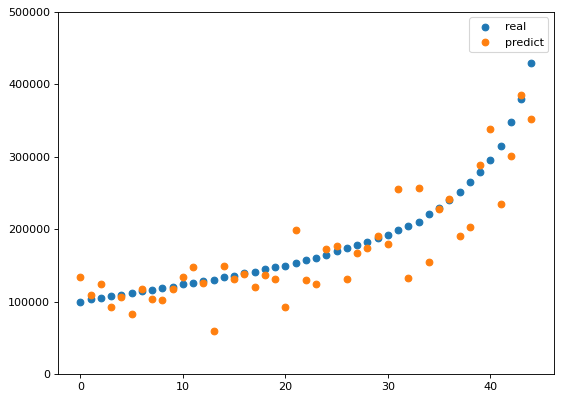

In [43]:
figure(figsize=(8, 6), dpi=80)

plt.ylim(0, 500_000)
plt.scatter(high_cost_indexes, [x[0] for x in high_cost_pairs_to_plot], label = "real")
plt.scatter(high_cost_indexes, [x[1] for x in high_cost_pairs_to_plot], label = "predict")

plt.legend()
plt.show()

# Summary

Combining two models gives the best metric values.

The results are promising considering the fact, that there are more factors which are not present in the dataset that impact the price of given car (like information about past car accidents).

For common car models in Poland, both models should return quite accurate information about the estimated price of the car.
